In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import scipy.io as sio

C:\Users\labuser\.conda\envs\custom_segnet\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## global variables

VERSION = 1.0
NUM_CLASSES = 10
SAVED_MODEL_NAME = 'deeplab_resnet50_model'
INPUT_SIZE = 512

print("Using GPU: ", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using GPU:  True


In [3]:
## path to directories
model_save_dir = r'\\babyserverdw3\PW Cloud Exp Documents\Lab work documenting\W-22-09-10 AT Build Competent multi task DL model for tissue labeling/saved_models/230110/{}x{}_v{}_50'.format(INPUT_SIZE, INPUT_SIZE, VERSION)  
path_to_saved_model = os.path.join(model_save_dir,'{}.tar'.format(SAVED_MODEL_NAME))

out_dir = r'\\babyserverdw3\PW Cloud Exp Documents\Lab work documenting\W-22-09-10 AT Build Competent multi task DL model for tissue labeling\out\230110_50'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    os.mkdir(os.path.join(out_dir, 'v{}'.format(VERSION)))
    
out_save_dir = os.path.join(out_dir, '{}/'.format(SAVED_MODEL_NAME))
if not os.path.exists(out_save_dir):
    os.mkdir(out_save_dir)
    os.mkdir(os.path.join(out_save_dir, 'eval'))
    os.mkdir(os.path.join(out_save_dir, 'patched'))

patched_dir = os.path.join(out_save_dir, 'patched')
eval_dir = os.path.join(out_save_dir, 'eval')

In [4]:
raw_im_dir = r'\\babyserverdw5\Digital pathology image lib\JHU\Ie-Ming Shih\lymphocytes\230110 dataset\raw\images'

im_list = [os.path.join(raw_im_dir, f) for f in os.listdir(raw_im_dir) if f[-3:] != '.db']

In [5]:
model = torchvision.models.segmentation.deeplabv3_resnet50('COCO_WITH_VOC_LABELS_V1')
model.classifier[4] = torch.nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = torch.nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
model = model.to(device)

state_dict = torch.load(path_to_saved_model)
model.load_state_dict(state_dict)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [6]:
def process_inp(inp):
    x = inp / 255 # normalize
    x = np.expand_dims(x, axis=0) # add N dim
    x = np.moveaxis(x, -1, 1) # modify x from NHWC to NCHW
    x = torch.from_numpy(x).type(torch.float32) # convert to torch
    return x

In [7]:
# def model(x):
#     return 1 - x 

I = INPUT_SIZE                             # input dimension
p = 0.5                             # fraction in center to predict
pad_style = 'symmetric'

# loop through raw images

for img in im_list:
    org_img = cv2.imread(img) # read in original image
    H, W = org_img.shape[0], org_img.shape[1] # original image dimension

    # H, W = 6671, 6732                   # original image dimension
    rand_img = np.random.rand(H, W)      # creating a fake image

    ### 1 - calcualte the size of the center crop

    c = int(np.sqrt(p) * I)
    c += (I-c) % 2                      # make sure the pad = (I-c) / 2 is a whole number


    ### 2.1 - find the pad to make the image dimension a multiple of the center - since we are using a step size of c
    bottom_pad = c - H % c
    right_pad = c - W % c
    multiple_img = np.pad(org_img, ((0, bottom_pad), (0, right_pad), (0, 0)), pad_style)


    ### 2.2 - finding pad to allow input dimension of I for the grid cells in the border
    pad = (I-c) // 2


    ### 2.3 - creating the final image that has the border pading
    padded_img = np.pad(multiple_img, ((pad, pad), (pad, pad), (0, 0)), pad_style)


    ### 3 - store the patches of dimension (I,I) mapping the center pad index hi wi 

    h, w = multiple_img.shape[0] // c, multiple_img.shape[1] // c
    grid_patches = [[ None for wi in range(w)] for hi in range(h)]

    Hp = c*h + I - c    # padded_img.shape[0]
    Wp = c*w + I - c    # padded_img.shape[1]

    for hi in range(h):
        for wi in range(w):
            left = wi*c
            right = left + I
            top = hi*c
            bottom = top + I

            grid_patches[hi][wi] = padded_img[top:bottom, left:right]


    ### 4 - stitch the paddes back into the image while only keeping the center crop of dimension (c,c)

    new_image = np.zeros((h*c, w*c))

    for hi in range(h):
        for wi in range(w):
            left = wi*c
            right = left + c
            top = hi*c
            bottom = top + c

            inp = grid_patches[hi][wi]
            assert inp.shape[0] == I and inp.shape[1] == I
            
            model_inp = process_inp(inp).cuda()
            
            with torch.no_grad():
                model_pred = model(model_inp)['out'][0, :NUM_CLASSES-1]   # (NUM_CLASSES-1, H, W)
            
            pred = torch.argmax(model_pred, 0).cpu().numpy()              
            new_image[top:bottom, left:right] = pred[pad:-pad, pad:-pad]

    final_pred = new_image[:H, :W]
    print(np.unique(final_pred))

    print('Input Dimension: ({0}, {0})  |  Crop Dimension: ({1}, {1})'.format(I, c))
    print('Generated Grid Size: ({}, {})'.format(len(grid_patches), len(grid_patches[0])) )
    print('Original Shape: {}  |  Mutilples Shape: {}  |  Padded Shape: {}  |  Prediction Shape: {}'.format(org_img.shape, multiple_img.shape, padded_img.shape, final_pred.shape))
    
#     plt.imshow(final_pred)
    
    fn = os.path.splitext(os.path.basename(img))[0]    
    cv2.imwrite(patched_dir + '/{}.tif'.format(fn), final_pred.astype('uint8'))
    print(fn)
    

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Input Dimension: (512, 512)  |  Crop Dimension: (362, 362)
Generated Grid Size: (19, 19)
Original Shape: (6732, 6671, 3)  |  Mutilples Shape: (6878, 6878, 3)  |  Padded Shape: (7028, 7028, 3)  |  Prediction Shape: (6732, 6671)
303_roi01_ROI-STIC
[0. 1. 2. 3. 4. 5. 6.]
Input Dimension: (512, 512)  |  Crop Dimension: (362, 362)
Generated Grid Size: (11, 13)
Original Shape: (3774, 4531, 3)  |  Mutilples Shape: (3982, 4706, 3)  |  Padded Shape: (4132, 4856, 3)  |  Prediction Shape: (3774, 4531)
303_roi02_ROI-normal
[0. 1. 2. 3. 4. 5. 6. 8.]
Input Dimension: (512, 512)  |  Crop Dimension: (362, 362)
Generated Grid Size: (18, 16)
Original Shape: (6481, 5632, 3)  |  Mutilples Shape: (6516, 5792, 3)  |  Padded Shape: (6666, 5942, 3)  |  Prediction Shape: (6481, 5632)
304_roi01_ROI-STIC
[0. 1. 2. 3. 4. 5. 6. 8.]
Input Dimension: (512, 512)  |  Crop Dimension: (362, 362)
Generated Grid Size: (20, 14)
Original Shape: (7092, 4925, 3)  |  Mutilples Shape: (7240, 5068, 3

In [10]:
## evaluate now

# path to raw labels
gt_dir = r'\\babyserverdw5\Digital pathology image lib\JHU\Ie-Ming Shih\lymphocytes\230110 dataset\raw\raw_labels'
pred_dir = patched_dir


processing 303_roi01_ROI-STIC...
[0 1 2 3 4 5 6 7 8]
processing 303_roi02_ROI-normal...
[0 1 2 3 4 5 6]
processing 304_roi01_ROI-STIC...
[0 1 2 3 4 5 6 8]
processing 304_roi02_ROI-normal...
[0 1 2 3 4 5 6 8]
processing 305_roi01_ROI-STIC...
[0 1 2 3 4 5 6 7 8]
processing 305_roi02_ROI-normal...
[0 1 2 3 4 5 6 7 8]
processing FTE363_roi01_ROI-STIC...
[0 1 2 3 4 5 6 7 8]
processing FTE363_roi02_ROI-carcinoma...
[0 1 2 3 4 5 6 7 8]
processing FTE363_roi03_ROI-normal...
[0 1 2 3 4 5 6 7 8]
processing FTE372 5G_roi01_ROI-STIC...
[0 1 2 3 4 5 6 7 8]
processing FTE372 5G_roi02_ROI-carcinoma...
[0 1 2 3 4 5 6 7 8]
processing FTE372 5G_roi03_ROI-normal...
[0 1 2 3 4 5 6 7 8]
processing FTE379_roi01_ROI-STIC...
[0 1 2 3 4 5 6 7 8]
processing FTE379_roi02_ROI-normal...
[0 1 2 3 4 5 6 7 8]
processing FTE379_roi03_ROI-carcinoma...
[0 1 2 3 4 5 6 7 8]


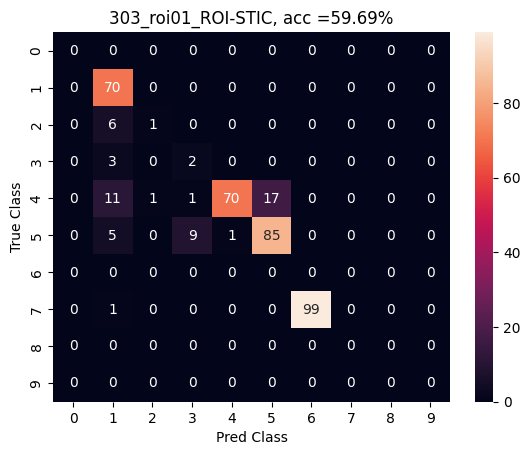

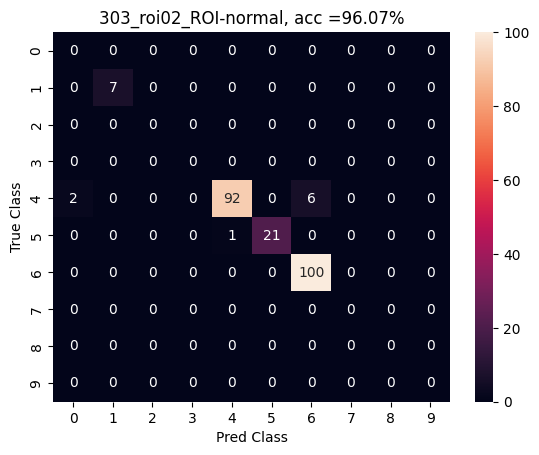

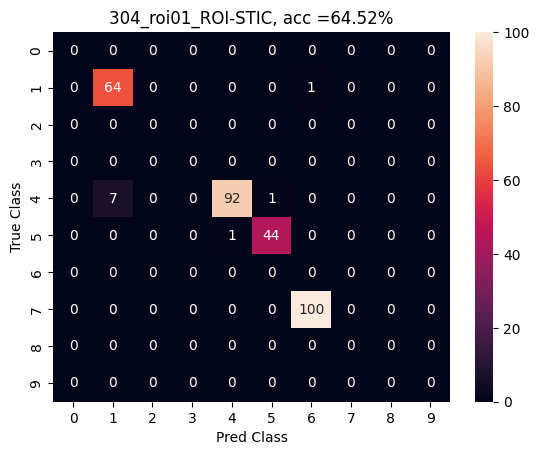

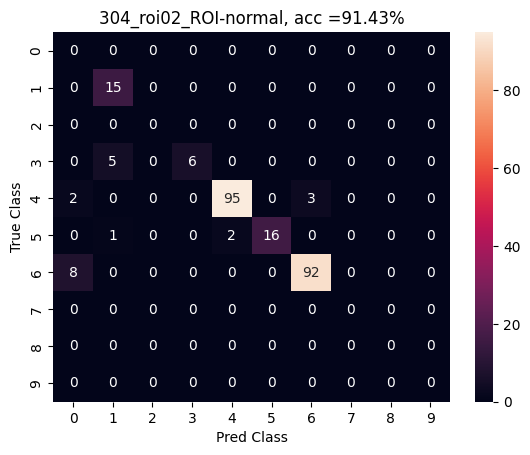

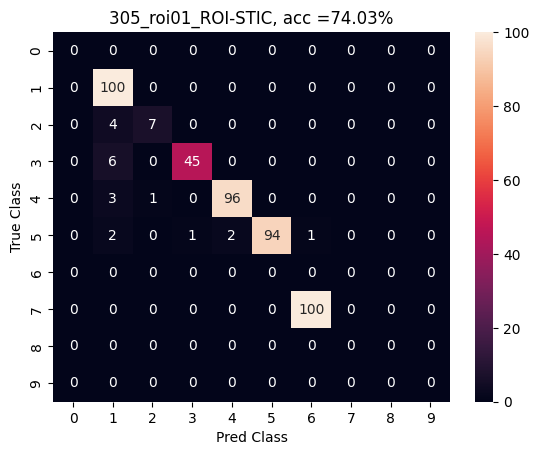

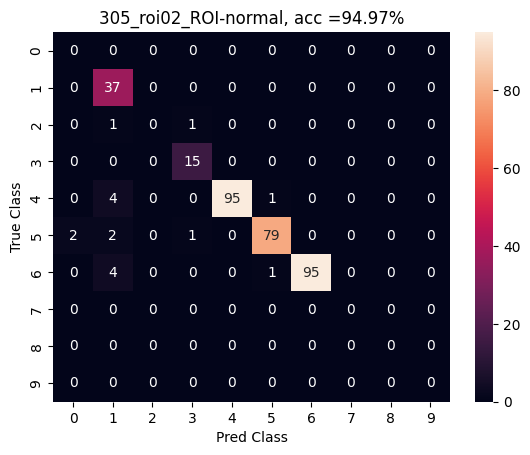

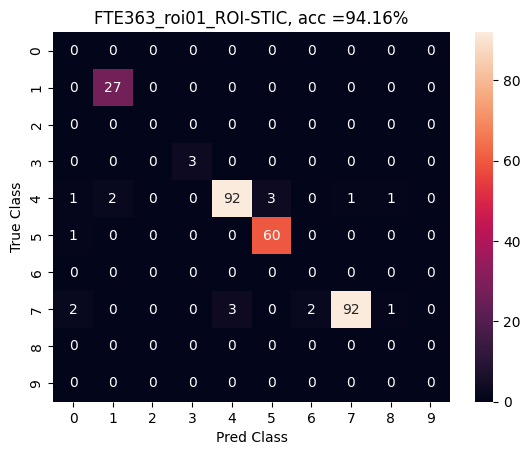

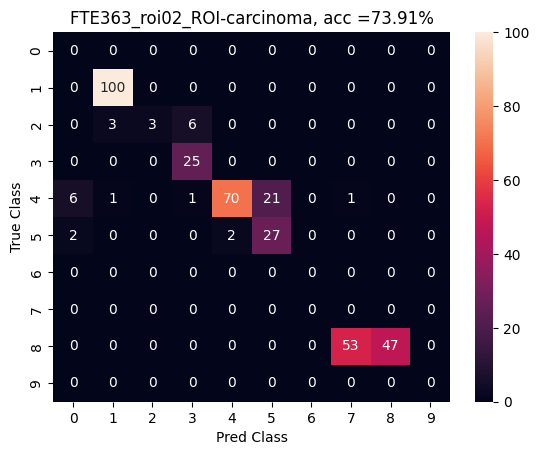

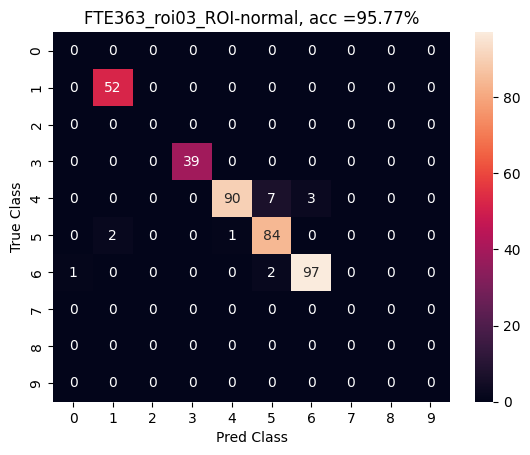

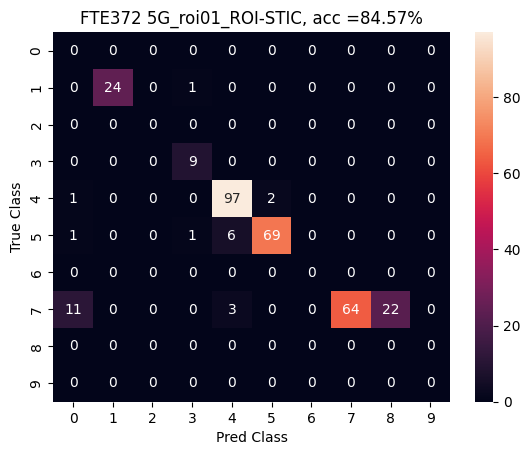

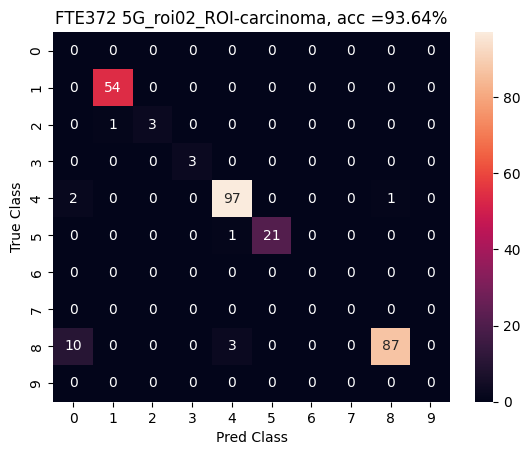

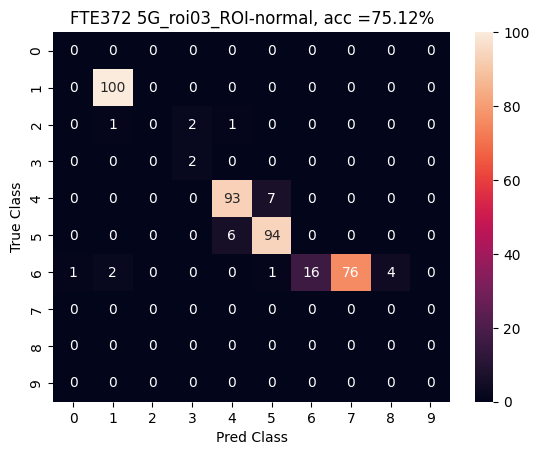

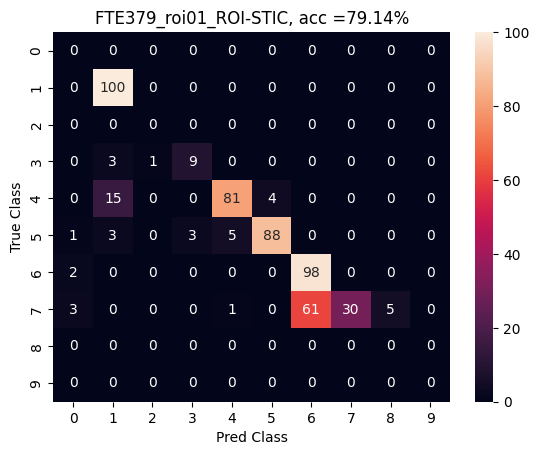

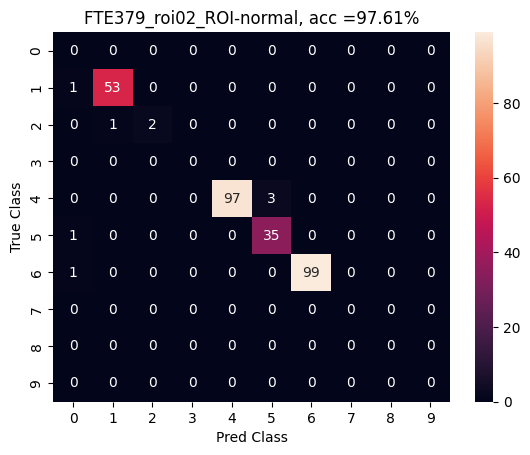

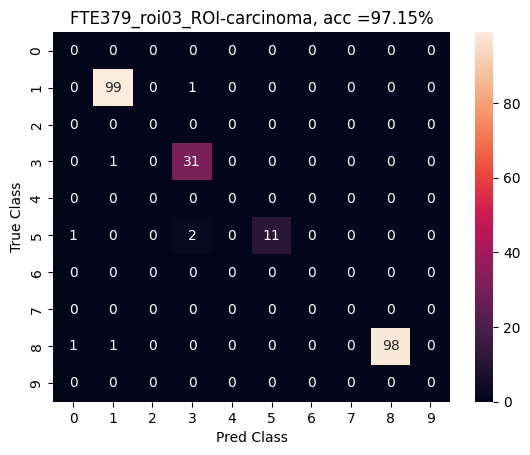

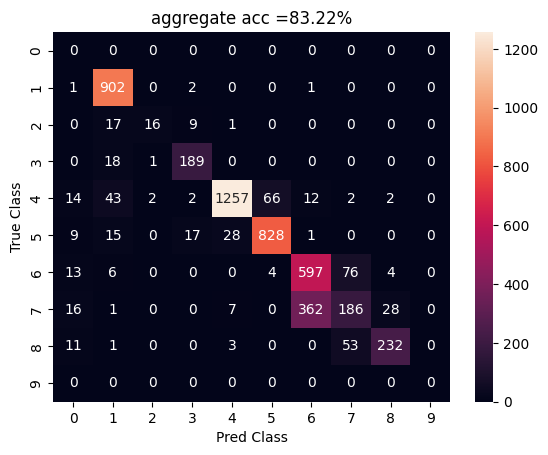

In [11]:
result_dict = {}
# aggregate confusion matrix
agg_cm = np.zeros((NUM_CLASSES, NUM_CLASSES)) 

for fn in os.listdir(pred_dir):
    im_name = fn[:-4]
    print('processing {}...'.format(im_name))
    # get predicted type map
    pred_tm = cv2.imread(os.path.join(pred_dir, fn), cv2.IMREAD_UNCHANGED)
    # get gt labels
    gt_fn = im_name + '_update.xlsx'
    gt_file = os.path.join(gt_dir, gt_fn)
    csvfile = pd.read_excel(gt_file)
    y = np.array(csvfile['ycrop'].values).astype('uint64')
    x = np.array(csvfile['xcrop'].values).astype('uint64')
    true = np.array(csvfile['type id'].values).astype('uint64')
    pred_type = pred_tm[y, x] # instances of predicted nuclei with gt labels
    print(np.unique(pred_tm))
    
    pred = pred_type.squeeze()
    ## get accuracy and output confusion matrix
    acc = np.sum(pred == true) / len(pred)
    result_dict['accuracy'] = acc
    
    cm = confusion_matrix(true, pred)

    # ensure all confusion matrices have same dimensions
    for c in range(NUM_CLASSES):
        if (c not in pred) and (c not in true):
            # pad with zeros
            cm = np.insert(cm, c, 0, axis=1)
            cm = np.insert(cm, c, 0, axis=0)

    result_dict['conf_mat'] = cm
    
    plt.figure()
    g = sn.heatmap(cm, annot=True, fmt='.5g')
    plt.xlabel('Pred Class')
    plt.ylabel('True Class')
    plt.title('{}, acc ={:.2f}%'.format(im_name, acc*100))
    
    ## save figures for each image
    plt.savefig(os.path.join(eval_dir, '{}_CM.png'.format(im_name)))
    sio.savemat(os.path.join(eval_dir, '{}_eval.mat'.format(im_name)), mdict=result_dict)
    
    # add  to aggregate confusion matrix
    agg_cm = agg_cm + cm

agg_result_dict = {}
agg_result_dict['conf_mat'] = agg_cm
# compute aggregate accuracy
agg_acc = np.trace(agg_cm) / np.sum(agg_cm)
agg_result_dict['accuracy'] = agg_acc

plt.figure()
g = sn.heatmap(agg_cm, annot=True, fmt='.5g')
plt.xlabel('Pred Class')
plt.ylabel('True Class')
plt.title('aggregate acc ={:.2f}%'.format(agg_acc*100))
## save figures for each image
plt.savefig(os.path.join(eval_dir, 'aggregate_CM.png'))
sio.savemat(os.path.join(eval_dir, 'aggregate_eval.mat'), mdict=agg_result_dict)
